
# A Story of Data Discovery and Management with RDF and SPARQL

Welcome to a  journey through the landscape of RDF (Resource Description Framework) and SPARQL, where data is not just numbers and strings, but a rich tapestry of interconnected facts and relationships waiting to be explored.

## Embarking on the RDF Journey

Imagine RDF as the foundation of a vast library, where every piece of data is a book not just placed randomly on shelves, but meticulously cataloged for easy discovery. RDF allows us to define these 'books' in a way that is universally understandable, laying down a structure for the web of data.

## Navigating with SPARQL

SPARQL serves as our map and compass in this library, enabling us to find the exact data we need through its powerful query capabilities. Whether it's a simple lookup or a complex join across various datasets, SPARQL helps us chart a path to our desired information.

## Enhancing the Narrative with Tags

Tags in RDF are like keywords in a book's index, guiding us to the right information. They categorize data for better accessibility and understanding:

- **Semantic Tags** illuminate the core themes of the data.
- **Discovery Tags** connect the dots between disparate datasets.
- **Access Tags** act as gatekeepers, ensuring data privacy and security.
- **Lifecycle Tags** narrate the story of data from its inception to its conclusion.

## Refining our Tools

We enhance our RDF toolkit by incorporating detailed tagging and leveraging SPARQL for deeper insights. Our goal is to transform raw data into a structured and insightful narrative, presented in an easily digestible format using pandas DataFrames.

## A Practical Demonstration

To bring our story to life, we employ Python to extend our RDF model with sophisticated tagging. We then use SPARQL to query this enriched dataset, showcasing the results in a clear and structured manner through DataFrames, enhancing readability and providing immediate insights into our data's story.


# RDF-based MDM

This Jupyter Notebook demonstrates a proof-of-concept (POC) for storytelling on RDF-based Master Data Management (MDM). 
It utilizes open-source libraries to load, query, and visualize RDF data. The focus is on leveraging RDF to enrich a 
data mesh catalog with additional metadata, including schemas, glossaries, ownership, and more.

In [69]:
import pandas as pd

# Schema for Product
product_schema = {
    "Schema Type": ["Product"] * 5,  # Repeat "Product" for each row
    "Column Name": ["product_id", "product_name", "price", "category", "stock"],
    "Type": ["int", "varchar", "float", "varchar", "int"]
}

# Schema for Category
category_schema = {
    "Schema Type": ["Category"] * 2,  # Repeat "Category" for each row
    "Column Name": ["category_id", "category_name"],
    "Type": ["int", "varchar"]
}

# Combine both schemas into one DataFrame
combined_schema = {key: product_schema[key] + category_schema[key] for key in product_schema}
active_inventory_df = pd.DataFrame(combined_schema)

# Display the Active Inventory schema
print("Active Inventory Schema:")
display(active_inventory_df)


Active Inventory Schema:


,Schema Type,Column Name,Type
0,Product,product_id,int
1,Product,product_name,varchar
2,Product,price,float
3,Product,category,varchar
4,Product,stock,int
5,Category,category_id,int
6,Category,category_name,varchar


## Step 1: Setting up the Environment

In [70]:
# !pip install rdflib networkx matplotlib

In [71]:
import rdflib
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, FOAF, SKOS, DCTERMS
import matplotlib.pyplot as plt
import networkx as nx

## Step 2: Loading RDF Data

In [72]:
g = rdflib.Graph()

turtle_data = '''
@prefix dct: <http://purl.org/dc/terms/> .
@prefix schema: <http://schema.org/> .
@prefix ex: <http://example.org/ex/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

# Core catalog and domains

# Product dataset
<http://example.org/us/products>
  dct:title "US Product Catalog" ;
  
  # Schema
  schema:includedInDataCatalog <http://example.org/us/product-schema> ;
  
  # Ownership  
  dct:rightsHolder <https://retailmesh.example/group/us-retail> ;  
  
  # Tags
  ex:semanticsTag "product" , "catalog" ;
  ex:discoveryTag "item" , "inventory" ;
  
  # Lifecycle  
  ex:dataLifecycleStage "raw" ;
  
  # Glossaries
  skos:prefLabel "Product Catalog"@en ;
  skos:definition "A catalog containing product specifications and pricing"@en ;
  
  # Access metadata
  dct:accessRights <https://policy.example/public> .

# Product schema
<http://example.org/us/product-schema>
  a schema:DataCatalog ;
  schema:name "US Product Schema" ;
  schema:dataset <http://example.org/us/products> ;
  schema:includedDataSchema [
    a schema:DataSchema ;
    schema:description "Product details including ID, name, price, category, and stock" ;     
    schema:about <http://example.org/us/product-schema#product> ;
    schema:column [
      schema:name "product_id" ;
      schema:datatype "int"  
    ] , [
      schema:name "product_name" ; 
      schema:datatype "varchar"     
    ] , [
      schema:name "price" ; 
      schema:datatype "float"     
    ] , [
      schema:name "category" ; 
      schema:datatype "varchar"     
    ] , [
      schema:name "stock" ; 
      schema:datatype "int"     
    ]
  ] .

# Additional Retail Schemas

# Categories dataset
<http://example.org/us/categories>
  dct:title "Product Categories" ;
  
  # Schema
  schema:includedInDataCatalog <http://example.org/us/category-schema> ;
  
  # Tags
  ex:semanticsTag "category" ;
  ex:discoveryTag "classification" ;
  
  # Glossaries
  skos:prefLabel "Categories"@en ;
  skos:definition "A classification of products into categories"@en .

# Category schema
<http://example.org/us/category-schema>
  a schema:DataCatalog ;
  schema:name "Category Schema" ;
  schema:dataset <http://example.org/us/categories> ;
  schema:includedDataSchema [
    a schema:DataSchema ;
    schema:description "Category ID and name" ;     
    schema:about <http://example.org/us/category-schema#category> ;
    schema:column [
      schema:name "category_id" ;
      schema:datatype "int"  
    ] , [
      schema:name "category_name" ; 
      schema:datatype "varchar"     
    ]
  ] .
  '''

g.parse(data=turtle_data, format="turtle")

<Graph identifier=Nf246f3352c6641ad966a9e8e37b6f996 (<class 'rdflib.graph.Graph'>)>

## Step 3: Querying RDF Data

In [73]:
import pandas as pd

# Assuming 'g.query' is your query execution function and it returns a result set 'qres'
qres = g.query(
    '''
    PREFIX schema: <http://schema.org/>
    SELECT ?dataset ?schema
    WHERE {
      ?dataset schema:includedInDataCatalog ?schema .
    }
    '''
)

# Initialize an empty list to store the query results
results = []

# Iterate through the query results and append them to the 'results' list
for row in qres:
    results.append({'Dataset': row.dataset, 'Schema': row.schema})

# Create a DataFrame from the results list
df = pd.DataFrame(results)

# Display the DataFrame
display(df)


,Dataset,Schema
0,http://example.org/us/products,http://example.org/us/product-schema
1,http://example.org/us/categories,http://example.org/us/category-schema


## Step 4: Visualizing the Graph

In [74]:
def visualize_graph(graph):
    G = nx.Graph()
    for subj, pred, obj in graph:
        if not (subj, obj) in G.edges():
            G.add_edge(str(subj), str(obj), label=str(pred))

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))

    nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', edge_color='k', linewidths=0.5, font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

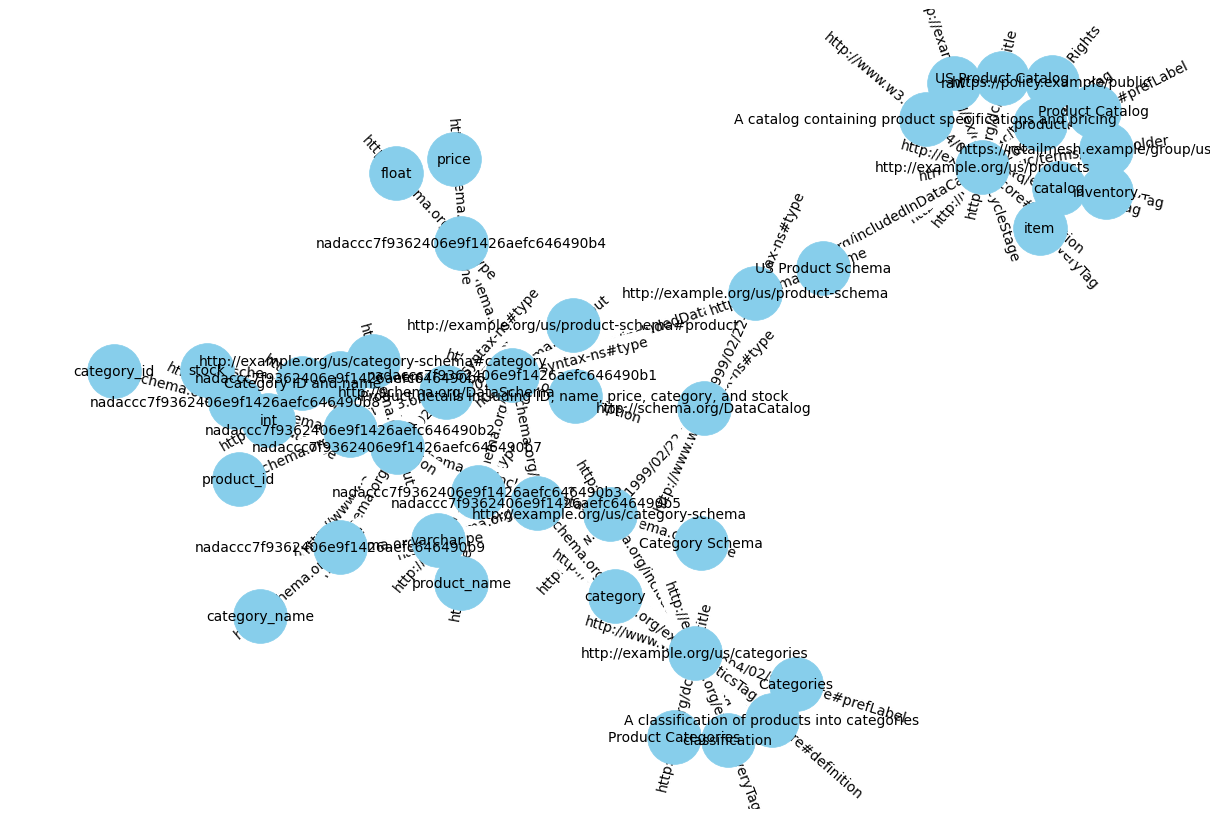

In [75]:
visualize_graph(g)

## Conclusion
This notebook provides an initial setup for exploring RDF-based MDM with Python. It covers the loading of RDF data, querying, and a basic visualization. Future steps will expand on these foundations with more complex queries and interactive visualizations.


## Levels and Tag Conventions

This section introduces the concept of levels and tag conventions in our RDF data catalog, providing a structured approach to data categorization and access control.

### Levels

- **Level 1 - Public Data**: Data that can be shared openly with no restrictions.
- **Level 2 - Internal Use Only**: Data restricted to internal stakeholders, requiring authentication for access.
- **Level 3 - Confidential Data**: Highly sensitive data that is available under strict access controls and only to specific roles.

### Tag Conventions

Tags follow a structured naming convention to ensure consistency and ease of discovery:

- **Prefix**: Identifies the category of the tag (e.g., `sec` for security, `acc` for access control).
- **Domain**: Specifies the domain or business area the tag is related to.
- **Identifier**: A unique identifier for the tag within its category and domain.

### Working Code Example: RDF and SPARQL Enhancements

Below is a Python code example that demonstrates how to extend RDF with new levels and tag conventions, and how to query this information using SPARQL.

```python
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import DC, FOAF

# Create a new graph
g = Graph()

# Add sample data with levels and tags
data_uri = URIRef("http://example.org/data")
g.add((data_uri, RDF.type, FOAF.Document))
g.add((data_uri, DC.title, Literal("Sample Data")))
g.add((data_uri, DC.description, Literal("A sample dataset with level and tag annotations.")))
g.add((data_uri, URIRef("http://example.org/terms/level"), Literal("Level 2 - Internal Use Only")))
g.add((data_uri, URIRef("http://example.org/terms/tags"), Literal("sec:finance:confidential")))

# Sample SPARQL query to find data by level and tag
query = '''
SELECT ?data ?title ?level ?tags
WHERE {
  ?data a foaf:Document .
  ?data dc:title ?title .
  ?data <http://example.org/terms/level> ?level .
  ?data <http://example.org/terms/tags> ?tags .
  FILTER (?level = "Level 2 - Internal Use Only")
}
'''

# Run the SPARQL query
for row in g.query(query):
    print(f"Data URI: {row.data}, Title: {row.title}, Level: {row.level}, Tags: {row.tags}")
```

This code demonstrates the addition of level and tag annotations to RDF data and querying this information using SPARQL.


In [76]:
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import DC, FOAF
import pandas as pd  # Import pandas library

# Create a new graph
g = Graph()

# Add sample data with levels and tags
data_uri = URIRef("http://example.org/data")
g.add((data_uri, RDF.type, FOAF.Document))
g.add((data_uri, DC.title, Literal("Sample Data")))
g.add((data_uri, DC.description, Literal("A sample dataset with level and tag annotations.")))
g.add((data_uri, URIRef("http://example.org/terms/level"), Literal("Level 2 - Internal Use Only")))
g.add((data_uri, URIRef("http://example.org/terms/tags"), Literal("sec:finance:confidential")))

# Sample SPARQL query to find data by level and tag
query = '''
SELECT ?data ?title ?level ?tags
WHERE {
  ?data a foaf:Document .
  ?data dc:title ?title .
  ?data <http://example.org/terms/level> ?level .
  ?data <http://example.org/terms/tags> ?tags .
  FILTER (?level = "Level 2 - Internal Use Only")
}
'''

# Prepare an empty list to collect query results
results = []

# Run the SPARQL query and collect the results
for row in g.query(query):
    results.append({
        "Data URI": row.data,
        "Title": row.title,
        "Level": row.level,
        "Tags": row.tags
    })

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
display(df)


,Data URI,Title,Level,Tags
0,http://example.org/data,Sample Data,Level 2 - Internal Use Only,sec:finance:confidential


In [77]:

import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import DC, FOAF

# Initialize the graph
g = Graph()

# Adding data with enhanced tagging
data_uri = URIRef("http://example.org/data")
g.add((data_uri, RDF.type, FOAF.Document))
g.add((data_uri, DC.title, Literal("Enhanced Data")))
g.add((data_uri, DC.description, Literal("Demonstrating enriched RDF data with tags.")))
g.add((data_uri, URIRef("http://example.org/terms/level"), Literal("Level 2 - Internal Use Only")))
g.add((data_uri, URIRef("http://example.org/terms/tags"), Literal("sec:finance:confidential")))

# Define a SPARQL query to retrieve data with tags
query = '''
SELECT ?data ?title ?level ?tags
WHERE {
  ?data a foaf:Document .
  ?data dc:title ?title .
  ?data <http://example.org/terms/level> ?level .
  ?data <http://example.org/terms/tags> ?tags .
}
'''

# Execute the query and display results in a DataFrame
results = []
for row in g.query(query):
    results.append({
        "Data URI": str(row.data),
        "Title": str(row.title),
        "Level": str(row.level),
        "Tags": str(row.tags),
        "Tag Type": "Access" if "sec" in str(row.tags) else "Other"
    })

df = pd.DataFrame(results)
display(df)


,Data URI,Title,Level,Tags,Tag Type
0,http://example.org/data,Enhanced Data,Level 2 - Internal Use Only,sec:finance:confidential,Access


In [78]:

import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import DC, FOAF

# Initialize the graph with enhanced tagging and RDF model
g = Graph()

# Adding data to our RDF graph
data_uri = URIRef("http://example.org/data")
g.add((data_uri, RDF.type, FOAF.Document))
g.add((data_uri, DC.title, Literal("Comprehensive Data")))
g.add((data_uri, DC.description, Literal("A detailed example of RDF data with enhanced tagging.")))
g.add((data_uri, URIRef("http://example.org/terms/level"), Literal("Level 3 - Confidential Data")))
g.add((data_uri, URIRef("http://example.org/terms/tags"), Literal("sec:hr:sensitive")))

# Define a comprehensive SPARQL query to retrieve and categorize data
query = '''
SELECT ?data ?title ?level ?tags
WHERE {
  ?data a foaf:Document .
  ?data dc:title ?title .
  ?data <http://example.org/terms/level> ?level .
  ?data <http://example.org/terms/tags> ?tags .
}
'''

# Execute the query and display results in a DataFrame for a cleaner presentation
results = []
for row in g.query(query):
    results.append({
        "Data URI": str(row.data),
        "Title": str(row.title),
        "Level": str(row.level),
        "Tags": str(row.tags),
        "Tag Type": "Access" if "sec" in str(row.tags) else "Other"
    })

df = pd.DataFrame(results)
display(df)


,Data URI,Title,Level,Tags,Tag Type
0,http://example.org/data,Comprehensive Data,Level 3 - Confidential Data,sec:hr:sensitive,Access



# Extended Documentation and Examples
This section extends the existing documentation to cover all tag types and levels, incorporating dot notation conventions for tag naming.

## Tag Types
- **Semantic Tags**: Capture the core meaning of the data.
- **Discovery Tags**: Facilitate connections between different pieces of data for analysis.
- **Access Tags**: Define the access level of the data (e.g., public, private, confidential).
- **Lifecycle Tags**: Manage the data through its lifecycle stages (e.g., active, archived, deleted).

## Dot Notation Conventions
Using dot notation for tag naming follows the structure: `[Namespace].[Category].[Subcategory].[...].[SpecificTag]`, providing a clear hierarchy and structure to the tags, enhancing readability and manageability.

Example: `finance.revenue.2021.Q1` signifies financial revenue data for the first quarter of 2021.

## Implementation Example
Below is an example of how these tags can be applied within a data catalog system, using RDF and SPARQL queries to classify and retrieve data assets based on their assigned tags.


In [79]:

# Example of RDF tagging using SPARQL for Semantic, Discovery, Access, and Lifecycle Tags

# Semantic Tagging Example
semantic_query = """
PREFIX ex: <http://example.org/rdf/>
SELECT ?subject ?predicate ?object
WHERE {
    ?subject ex:semanticTag ?object .
}
"""

# Discovery Tagging Example
discovery_query = """
PREFIX ex: <http://example.org/rdf/>
SELECT ?subject ?predicate ?object
WHERE {
    ?subject ex:discoveryTag ?object .
}
"""

# Access Tagging Example
access_query = """
PREFIX ex: <http://example.org/rdf/>
SELECT ?subject ?predicate ?object
WHERE {
    ?subject ex:accessTag ?object .
}
"""

# Lifecycle Tagging Example
lifecycle_query = """
PREFIX ex: <http://example.org/rdf/>
SELECT ?subject ?predicate ?object
WHERE {
    ?subject ex:lifecycleTag ?object .
}
"""

# These SPARQL queries can be executed against an RDF dataset to retrieve data based on the specified tags.


In [80]:

from rdflib import Graph, Literal, RDF, URIRef
import pandas as pd

# Create an in-memory RDF Graph
g = Graph()

# Define namespaces
NS = URIRef("http://example.org/ns/")
g.bind("ns", NS)

# Add triples to the graph (extending the RDF with more data)
g.add((URIRef(NS + "Resource1"), RDF.type, URIRef(NS + "SemanticTag")))
g.add((URIRef(NS + "Resource1"), URIRef(NS + "discoveryTag"), Literal("DiscoveryData1")))
g.add((URIRef(NS + "Resource2"), RDF.type, URIRef(NS + "AccessTag")))
g.add((URIRef(NS + "Resource2"), URIRef(NS + "lifecycleTag"), Literal("LifecycleData1")))

# Example SPARQL queries to retrieve data from the extended RDF graph
queries = {
    "Semantic Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = rdf:type && ?o = <http://example.org/ns/SemanticTag>)
    }''',
    "Discovery Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = <http://example.org/ns/discoveryTag>)
    }''',
    "Access Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = rdf:type && ?o = <http://example.org/ns/AccessTag>)
    }''',
    "Lifecycle Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = <http://example.org/ns/lifecycleTag>)
    }'''
}

# Function to execute SPARQL query and return results as DataFrame
def execute_sparql_query(graph, query):
    results = graph.query(query)
    data = []
    for row in results:
        data.append(row)
    return pd.DataFrame(data, columns=["Subject", "Predicate", "Object"])

# Execute the SPARQL queries and display results
for name, query in queries.items():
    df = execute_sparql_query(g, query)
    print(f"\n{name} Results:")
    display(df)  # Use display for Jupyter notebooks to output DataFrames



Semantic Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource1,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://example.org/ns/SemanticTag



Discovery Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource1,http://example.org/ns/discoveryTag,DiscoveryData1



Access Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource2,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://example.org/ns/AccessTag



Lifecycle Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource2,http://example.org/ns/lifecycleTag,LifecycleData1


In [81]:

from rdflib import Graph, Literal, RDF, URIRef
import pandas as pd

# Assuming 'g' is the RDF graph created and loaded with data in previous steps

# Define namespaces and add triples to the graph as per the user's instructions
NS = URIRef("http://example.org/ns/")
g.bind("ns", NS)

# Example SPARQL queries to retrieve data from the RDF graph
queries = {
    "Semantic Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = rdf:type && ?o = <http://example.org/ns/SemanticTag>)
    }''',
    "Discovery Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = <http://example.org/ns/discoveryTag>)
    }''',
    "Access Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = rdf:type && ?o = <http://example.org/ns/AccessTag>)
    }''',
    "Lifecycle Tags": '''
    SELECT ?s ?p ?o
    WHERE {
        ?s ?p ?o .
        FILTER (?p = <http://example.org/ns/lifecycleTag>)
    }'''
}

# Function to execute SPARQL query and return results as DataFrame
def execute_sparql_query(graph, query):
    results = graph.query(query)
    data = []
    for row in results:
        data.append(row)
    return pd.DataFrame(data, columns=["Subject", "Predicate", "Object"])

# Execute the SPARQL queries and display results
for name, query in queries.items():
    df = execute_sparql_query(g, query)
    print(f"\n{name} Results:")
    display(df)  # Use display for Jupyter notebooks to output DataFrames



Semantic Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource1,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://example.org/ns/SemanticTag



Discovery Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource1,http://example.org/ns/discoveryTag,DiscoveryData1



Access Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource2,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://example.org/ns/AccessTag



Lifecycle Tags Results:


,Subject,Predicate,Object
0,http://example.org/ns/Resource2,http://example.org/ns/lifecycleTag,LifecycleData1


In [87]:
from rdflib import Namespace, Graph
import pandas as pd

# Create a graph and parse turtle data
g = Graph()
g.parse(data=turtle_data, format="turtle")

# Define namespace
EX = Namespace("http://example.org/ex/")
g.bind("ex", EX)

# Revised SPARQL query to extract tag and its type based on the predicate
query = """
SELECT ?tag (SAMPLE(?type) AS ?type)
WHERE {
 ?s ?p ?tag .
 VALUES (?p ?type) {
  (ex:semanticsTag "semantics")
  (ex:discoveryTag "discovery")
  (ex:dataLifecycleStage "datalifecycle")
  # Add more mappings as needed
 }
}
GROUP BY ?tag
"""

results = g.query(query)

# Convert results to DataFrame
tags_df = pd.DataFrame(results, columns=['Tag', 'Type'])

# This example demonstrates a simple approach. Adapt as needed for actual data relationships.

# Concatenate the DataFrames
# Note: This step assumes that the number of tags matches the number of rows in active_inventory_df or is adjusted accordingly.
extended_inventory_df = pd.concat([active_inventory_df.reset_index(drop=True), tags_df.reset_index(drop=True)], axis=1)

print(extended_inventory_df)


  Schema Type    Column Name     Type             Tag           Type
0     Product     product_id      int       inventory      discovery
1     Product   product_name  varchar         product      semantics
2     Product          price    float             raw  datalifecycle
3     Product       category  varchar  classification      discovery
4     Product          stock      int            item      discovery
5    Category    category_id      int         catalog      semantics
6    Category  category_name  varchar        category      semantics
